#Querying tables

> Objectives:
> * Compare queries of tabular data for **in-memory** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.031 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 30.676 MiB


In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.023 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 30.699 MiB


In [3]:
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': "S100", 'genres': "S100"})

In [3] used 78.227 MiB RAM in 0.758s, peaked 0.000 MiB above current, total RAM usage 108.926 MiB


In [4]:
lens = pd.merge(movies, ratings)

In [4] used 54.043 MiB RAM in 0.173s, peaked 0.000 MiB above current, total RAM usage 162.969 MiB


In [5]:
size_pandas = mw.measurements.memory_delta

In [5] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 162.977 MiB


In [6]:
lens[:10]
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 25.820 MiB RAM in 0.200s, peaked 0.000 MiB above current, total RAM usage 188.797 MiB


In [7]:
result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
t = %timeit -o lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']

10 loops, best of 3: 44 ms per loop
In [7] used 0.406 MiB RAM in 1.972s, peaked 0.000 MiB above current, total RAM usage 189.203 MiB


In [8]:
qtime_pandas = t.best

In [8] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 189.203 MiB


##Use a compressed in-memory container via `bcolz`

In [9]:
import bcolz
print bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     0.9.0
NumPy version:     1.9.2
Blosc version:     1.4.1 ($Date:: 2014-07-08 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.4.3
Python version:    2.7.10 |Anaconda 2.1.0 (64-bit)| (default, May 28 2015, 17:02:03) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
None


4

In [9] used 5.543 MiB RAM in 0.087s, peaked 0.000 MiB above current, total RAM usage 194.746 MiB


In [10]:
zlens = bcolz.ctable.fromdataframe(lens)

In [10] used 0.770 MiB RAM in 0.249s, peaked 155.840 MiB above current, total RAM usage 195.516 MiB


Sometimes the memory reported as used is too much biased (don't know why), so let's repeat the operation, but using a different container:

In [11]:
zlens2 = bcolz.ctable.fromdataframe(lens)

In [11] used 0.062 MiB RAM in 0.289s, peaked 44.707 MiB above current, total RAM usage 195.578 MiB


In [12]:
size_bcolz = mw.measurements.memory_delta

In [12] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 195.578 MiB


In [13]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.89 MB; ratio: 19.45
  cparams := cparams(clevel=5, shuffle=True, cname='lz4')
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [13] used 0.012 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 195.590 MiB


In [14]:
size_pandas / size_bcolz

864.6875

In [14] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 195.590 MiB


We can see that the space taken by a bcolz container is around 7x smaller (!) than a pandas one.

### Excercise 1

Why do you think that number of uncompressed bytes (nbytes) that the ctable reports is 3x more than pandas (153 MB vs 54 MB)?

*Hint:* Pandas stores the string columns in NumPy containers with 'object' dtype whereas bcolz uses the equivalent to NumPy's 'string' objects.

In [15]:
# Querying a bcolz dataset
resultz = [(r.nrow__, r.user_id) for r in zlens.where("(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]
t = %timeit -o [(r.nrow__, r.user_id) for r in zlens.where("(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['nrow__', 'user_id'])]

10 loops, best of 3: 24.3 ms per loop
In [15] used 0.352 MiB RAM in 1.140s, peaked 0.000 MiB above current, total RAM usage 195.941 MiB


In [16]:
qtime_bcolz = t.best

In [16] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 195.941 MiB


In [17]:
qtime_pandas / qtime_bcolz

1.8150627088533673

In [17] used 0.000 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 195.941 MiB


We see that bcolz containers, besides being in compressed state, provide ~2x faster query times than pandas

In [18]:
# Sanity check (always check for your results!)
print("results with pandas Dataframe:", result)
print("results with bcolz ctable:", resultz)

('results with pandas Dataframe:', 5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64)
('results with bcolz ctable:', [(5121, 75), (5164, 3842), (5187, 6031)])
In [18] used 0.000 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 195.941 MiB


## Using structured NumPy arrays

In [19]:
nalens = lens.to_records()

In [19] used 53.418 MiB RAM in 0.592s, peaked 0.000 MiB above current, total RAM usage 249.359 MiB


In [20]:
size_numpy = mw.measurements.memory_delta

In [20] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 249.363 MiB


In [21]:
resultna = nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
t = %timeit -o nalens[(nalens['title'] == 'Tom and Huck (1995)') & (nalens['rating'] == 5)]
resultna

10 loops, best of 3: 16.2 ms per loop


rec.array([ (5121, 8, 'Tom and Huck (1995)', "Adventure|Children's", 75, 5, 977851520),
       (5164, 8, 'Tom and Huck (1995)', "Adventure|Children's", 3842, 5, 967986151),
       (5187, 8, 'Tom and Huck (1995)', "Adventure|Children's", 6031, 5, 956718223)], 
      dtype=[('index', '<i8'), ('movie_id', '<i8'), ('title', 'O'), ('genres', 'O'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])

In [21] used 0.000 MiB RAM in 0.779s, peaked 0.000 MiB above current, total RAM usage 249.363 MiB


Again, NumPy works the fastest for in-memory data containers, while memory consumption is close to pandas.

In [22]:
qtime_numpy = t.best

In [22] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 249.363 MiB


##Performance comparsion

In [23]:
%matplotlib inline

In [23] used 7.691 MiB RAM in 0.142s, peaked 0.000 MiB above current, total RAM usage 257.055 MiB


/home/faltet/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1279: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


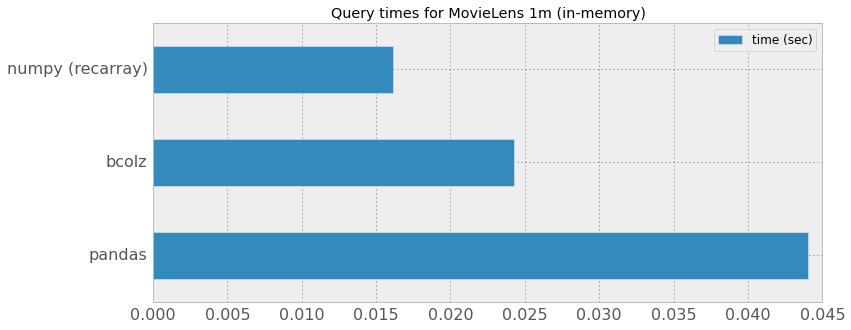

In [24] used 5.520 MiB RAM in 0.311s, peaked 0.000 MiB above current, total RAM usage 262.574 MiB


In [24]:
# Query times
labels = ["pandas", "bcolz", "numpy (recarray)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas, qtime_bcolz, qtime_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m (in-memory)")

## Size comparison

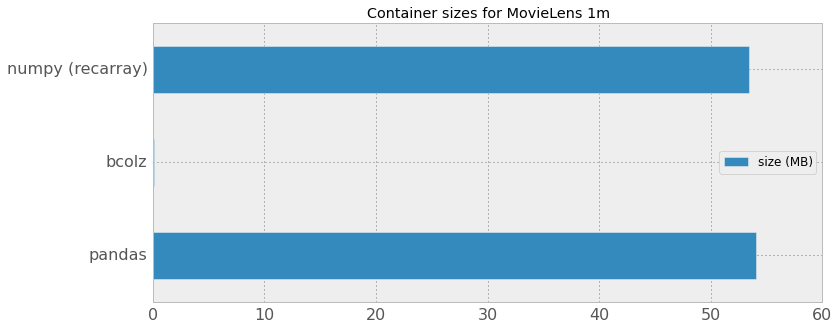

In [25] used 2.668 MiB RAM in 0.234s, peaked 0.000 MiB above current, total RAM usage 265.242 MiB


In [25]:
# Container sizes
df = pd.DataFrame({'size (MB)': [size_pandas, size_bcolz, size_numpy]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

## Rules of thumb for querying in-memory tabular datasets

* Choose pure NumPy recarrays if you need the fastest speed
* Choose bcolz ctables if you need to store lots of data in limited memory and not want to loose too much speed
* Choose pandas if what you need is rich functionality on top of your containers (at the penalty of some speed)